### Libraries

In [1]:
#files
from os import listdir
from os.path import isfile, join

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#computer vision
from skimage import io
import cv2 as cv

#classifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#file
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml')
moods = ['feliz','neutral','sorprendido','triste']

### Build data set

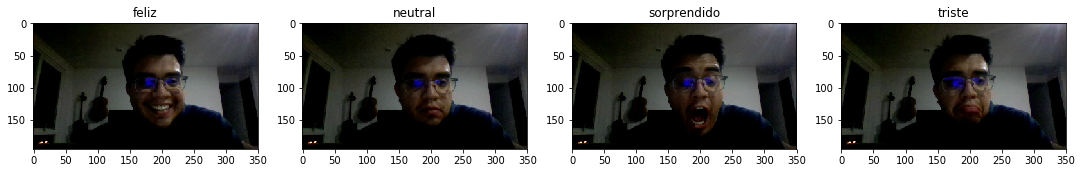

In [2]:
DBImages = {}
for m in moods:
    mypath = '../trainset/' + m + '/'
    files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    DBImages[m] = files

f = plt.figure()
f.set_size_inches(18.5, 10.5)

ix = 1
numberImg = 10 #CHANGE ON DEMO
for mood, imageList in DBImages.items():
    img = io.imread('../trainset/' + mood + '/' + imageList[numberImg])
    f.add_subplot(1,4,ix)
    plt.title(mood)
    plt.imshow(img)
    ix = ix + 1

### Detect Faces

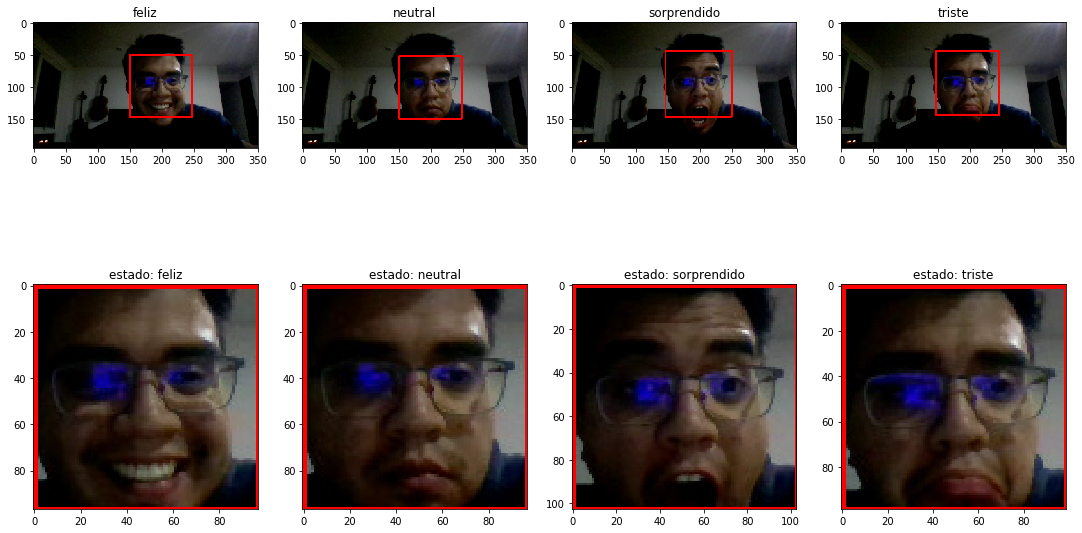

In [3]:
f = plt.figure()
f.set_size_inches(18.5, 10.5)

ixImg = 1
ixFace = 5
for mood, imageList in DBImages.items():
    #original image
    img = io.imread('../trainset/' + mood + '/' + imageList[0])
    #grayscale
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #detect faces
    faces = face_cascade.detectMultiScale(gray)
    #biggest face
    [x,y,w,h] = faces[0]
    #draw a rectangle
    cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    #display
    f.add_subplot(2,4,ixImg)
    plt.title(mood)
    plt.imshow(img)
    #crop only face
    roi_gray = img[y:y+h, x:x+w, :]
    #display
    f.add_subplot(2,4,ixFace)
    plt.title('estado: ' + mood)
    plt.imshow(roi_gray)
    #counters
    ixImg = ixImg + 1
    ixFace = ixFace + 1

### Kernel

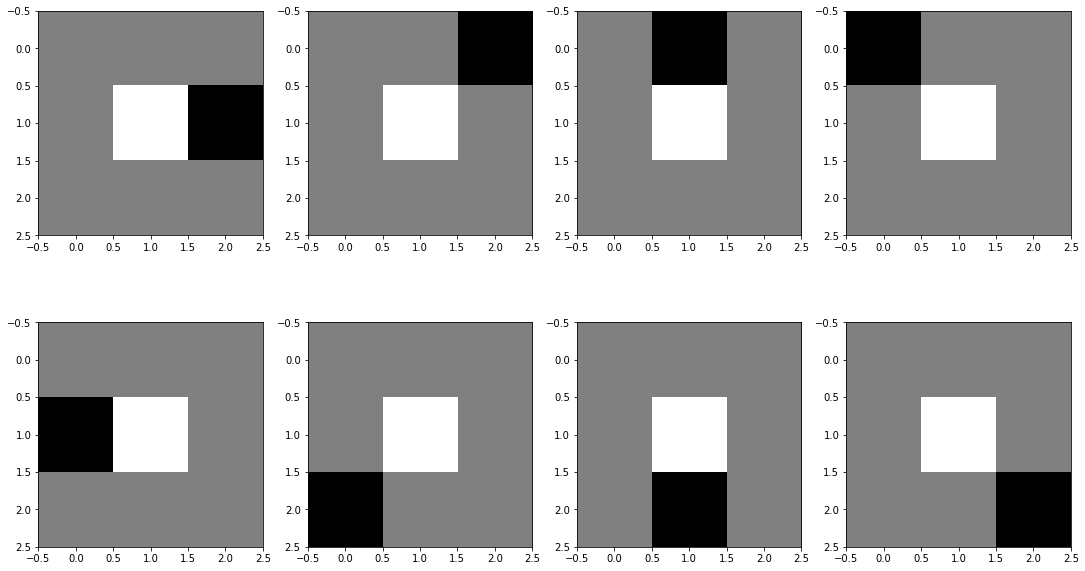

In [4]:
#create kernel
kernel = np.zeros((8,3,3),np.int32)
kernel[:,1,1] = 1
kernel[0,1,2] = -1
kernel[1,0,2] = -1
kernel[2,0,1] = -1
kernel[3,0,0] = -1
kernel[4,1,0] = -1
kernel[5,2,0] = -1
kernel[6,2,1] = -1
kernel[7,2,2] = -1

# Display
f = plt.figure()
f.set_size_inches(18.5, 10.5)

for ix in range(1,9):
    f.add_subplot(2,4,ix)
    plt.imshow(kernel[ix-1,:,:], cmap='gray')

### Convolution

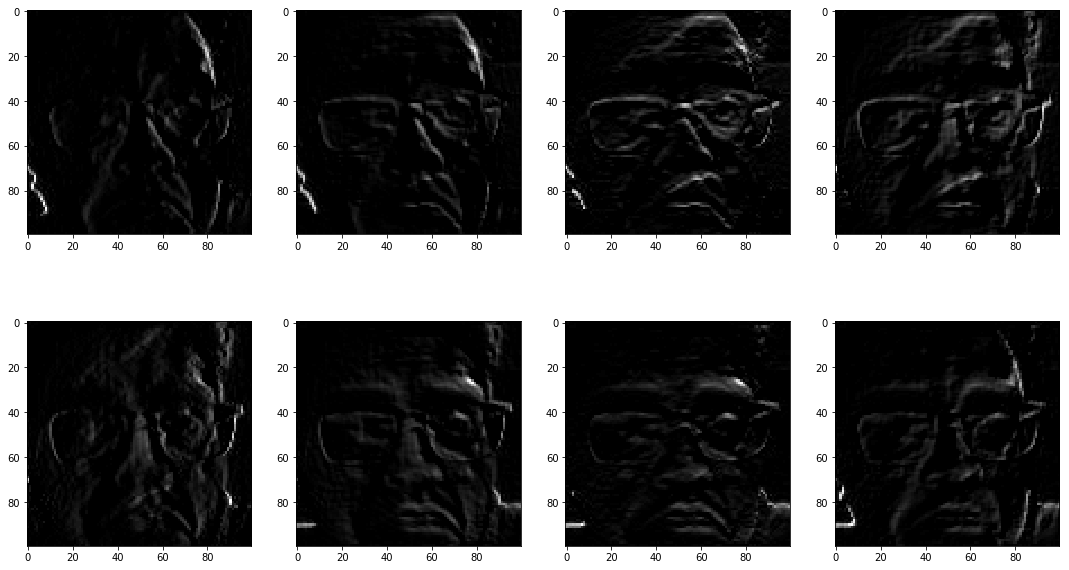

In [5]:
roi_gray = gray[y:y+h, x:x+w]
#normalize size
dim = (100, 100)
# resize image
resized = cv.resize(roi_gray, dim, interpolation = cv.INTER_AREA) 
#result storage
Cube = np.zeros((8,100,100),np.int32)
# Display
f = plt.figure()
f.set_size_inches(18.5, 10.5)
#filter
for i in range(0, 8):
    Cube[i,:,:] = cv.filter2D(resized,-1,kernel[i,:,:])            
    # Display
    f.add_subplot(2,4,i+1)
    plt.imshow(Cube[i,:,:], cmap='gray')

### Space Range

In [6]:
print('POSSIBLE')
print('Range value: [-255, 255]')
print('Space Bin: 512')
print('CURRENT')
minval = int(np.min(Cube[:]))
maxval = int(np.max(Cube[:]))
rangeval = (abs(minval) - 0) + maxval
print('Range value: [' + str(minval) + ', ' + str(maxval) + ']')
print('Space Bin: ' + str(rangeval))

POSSIBLE
Range value: [-255, 255]
Space Bin: 512
CURRENT
Range value: [0, 101]
Space Bin: 101


### Sort

Range value: [1, 62]


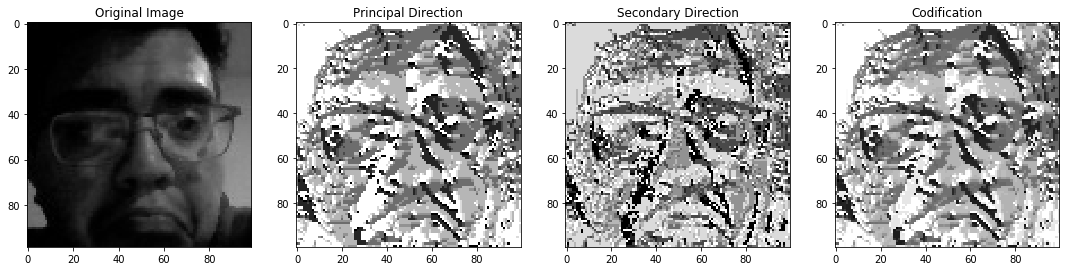

In [7]:
SortCube = Cube.argsort(axis=0)
#prominent directions
DirPrincipal = SortCube[7,:,:]
DirSecondary = SortCube[6,:,:]
#codification
Codification = DirPrincipal*8 + DirSecondary
# Display
f = plt.figure()
f.set_size_inches(18.5, 10.5)
# Display
f.add_subplot(2,4,1)
plt.title('Original Image')
plt.imshow(roi_gray, cmap='gray')
f.add_subplot(2,4,2)
plt.title('Principal Direction')
plt.imshow(DirPrincipal, cmap='gray')
f.add_subplot(2,4,3)
plt.title('Secondary Direction')
plt.imshow(DirSecondary, cmap='gray')
f.add_subplot(2,4,4)
plt.title('Codification')
plt.imshow(Codification, cmap='gray')
#range values
minval = int(np.min(Codification[:]))
maxval = int(np.max(Codification[:]))
print('Range value: [' + str(minval) + ', ' + str(maxval) + ']')

### Look up table transformation

In [8]:
#filter to reduce from 64 to 56
filt = [0,1,2,3,4,5,6,7,8,0,9,10,11,12,13,14,15,16,0,17,18,19,20,21,22,23,24,0,25,26,27,28,29,30,31,32,0,33,34,35,36,37,38,39,40,0,41,42,43,44,45,46,47,48,0,49,50,51,52,53,54,55,56,0]
filt = np.asarray(filt)
#look up table
lut = filt[Codification[:]]
#range values
minval = int(np.min(lut[:]))
maxval = int(np.max(lut[:]))
print('Range value: [' + str(minval) + ', ' + str(maxval) + ']')

Range value: [1, 56]


### Vectorial Representation

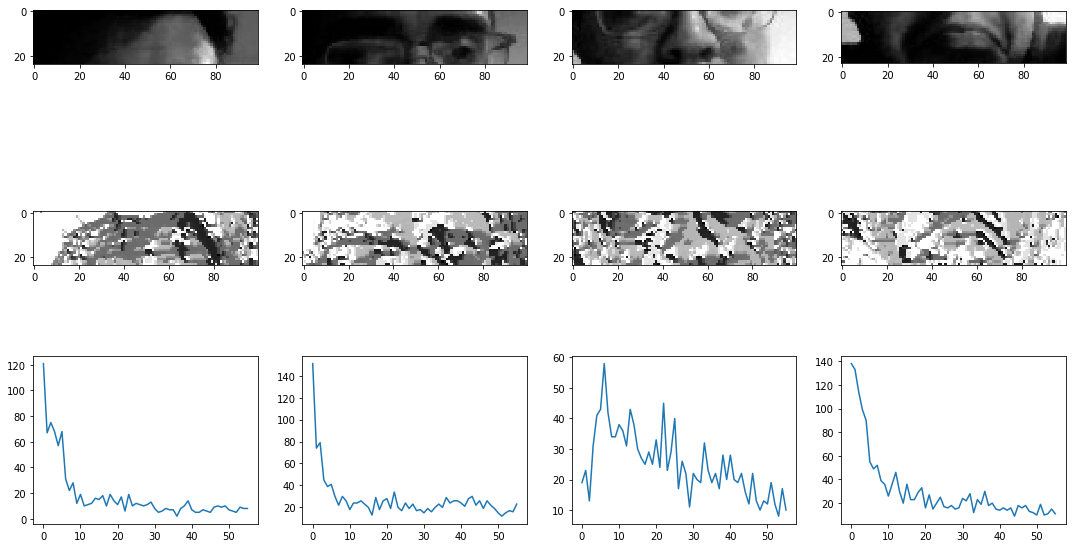

In [9]:
#calculate histograms
bigH = []
division = 4 #CHANGE ON DEMO
fragment = int(100/division)
# 1 - 100
# 2 - 50
# 4 - 25
# 5 - 20
# 10 - 10
# Display
f = plt.figure()
f.set_size_inches(18.5, 10.5)
ixI = 1
for div in range(1, 100, fragment):
    #display image
    cropGray = roi_gray[div:(div+fragment)-1,:]
    f.add_subplot(3,division,ixI)
    plt.imshow(cropGray, cmap='gray')
    #display lut
    cropLut = lut[div:(div+fragment)-1,:]
    f.add_subplot(3,division,ixI + division)
    plt.imshow(cropLut, cmap='gray')
    #calculate histogram
    smallH, bins = np.histogram(cropGray.ravel(),56,[1,56])
    # Display histogram
    f.add_subplot(3,division,ixI + division*2)
    plt.plot(smallH)
    #counter
    ixI = ixI + 1
    #concatenate
    bigH = bigH + smallH.tolist()

### Normalization

Histogram size accumulation: [1000]
Histogram size lenght: [224]


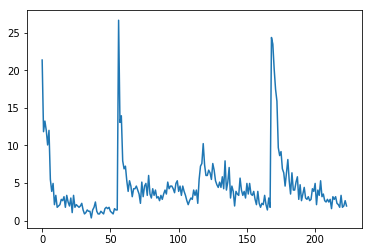

In [10]:
factor = 1000 #CHANGE ON DEMO
#normalize histogram
normH = (bigH/np.sum(bigH))*factor
#display
plt.plot(normH)
#accumulation
print('Histogram size accumulation: [' + str(int(sum(normH))) + ']')
print('Histogram size lenght: [' + str(int(len(normH))) + ']')

### Summary

In [11]:
X = []
Y = []
for mood, imageList in DBImages.items():
    print(mood)
    for imagePath in imageList:
        print(imagePath)
        path = '../trainset/' + mood + '/' + imagePath
        img = io.imread(path)
        #grayscale
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        #detect faces
        faces = face_cascade.detectMultiScale(gray)
        #biggest face
        [x,y,w,h] = faces[0]
        #crop only face
        roi_gray = gray[y:y+h, x:x+w]
        #normalize size
        dim = (100, 100)
        # resize image
        resized = cv.resize(roi_gray, dim, interpolation = cv.INTER_AREA) 
        #result storage
        Cube = np.zeros((8,100,100),np.int32)
        #filter
        for i in range(0, 8):
            Cube[i,:,:] = cv.filter2D(resized,-1,kernel[i,:,:])
        #sort by depth
        SortCube = Cube.argsort(axis=0)
        #prominent directions
        DirPrincipal = SortCube[7,:,:]
        DirSecondary = SortCube[6,:,:]
        #codification
        Codification = DirPrincipal*8 + DirSecondary
        #look up table
        lut = filt[Codification[:]]
        #calculate histograms
        bigH = []
        for div in range(1, 100, 25):
            hist,bins = np.histogram(lut[div:(div+25)-1,:].ravel(),56,[1,56])
            bigH = bigH + hist.tolist()
        #normalize histogram
        normH = (bigH/np.sum(bigH))*1000
        X.append(normH)
        Y.append(mood)

feliz
992cd3bc-e530-481a-94e0-74da631ac7ac.jpg
42b36ea5-bdb3-4b8c-9e15-c87d95b08391.jpg
20d07a36-09a2-4ef8-afc4-6cb3b8253000.jpg
8a1913f5-1d10-4384-9888-0e984aed2330.jpg
0fb566a4-b857-43f8-b9e7-6cab07a12a5c.jpg
c64d62b5-4f6e-4a15-9661-cc641099e558.jpg
97b5758d-86b3-4571-b27b-d04a3517ee4e.jpg
9a90c883-cd6c-4231-95d1-e86a51e0a6a9.jpg
7a893a38-fd1e-492f-a587-a14714c3cb55.jpg
14dbfa2c-a50b-4f7e-b4af-949fe1f9a8a5.jpg
3d4cdba7-eac2-445d-9f1b-f662d6756eb7.jpg
e6541522-1f14-4519-8ccd-d6ba4fbcaa5f.jpg
66b6ed51-58b2-43c4-abc8-b4c3a85afa4f.jpg
17b6de0e-2661-467d-a14d-65e493dcce3f.jpg
9baeabb7-e6bf-459b-8be7-355c56dbc7bd.jpg
a139bd69-6f33-4d30-aaa3-d0dbb9be3ba8.jpg
neutral
e1b3e492-2e65-467c-9303-5db7eb825003.jpg
489d8c18-ca2b-4b5f-84ff-c8f58ed3c301.jpg
ba6c8b73-c618-4566-bbce-ecaae733cfde.jpg
597be452-fb9b-4f3b-8bbd-0371fb2c01b6.jpg
77fec5db-4cf8-450f-a6ec-09aae9330ec7.jpg
72c96201-79bb-4112-be09-796b829a7af2.jpg
5cda5a61-edba-4590-9270-0dcf54b346bd.jpg
042157e8-1cd8-4acc-92ed-b38073f6aa5e.jpg
b8

### Split Train/Test

In [12]:
# 0.04 - 2
# 0.06 - 3
# 0.08 - 4
# 0.25 - 15
train_size_perc = 0.50 #CHANGE ON DEMO
test_size_perc = 1 - train_size_perc
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=test_size_perc, random_state=789)
print('total: ' + str(len(Y)))
print('train: ' + str(len(trainY)))
print('test: ' + str(len(testY)))

total: 60
train: 30
test: 30


# <font color='red'>Support Vector Machine </font>

In [13]:
#train the svm 
clf = svm.SVC(C=100, gamma='scale', probability=True, decision_function_shape='ovo')
clf.fit(trainX, trainY)
#compare prediction vs real
total = len(testY)
good = 0
for i in range(0,total):
    #get the prediction
    predict = clf.predict([testX[i]])
    #check if it is correct
    if(testY[i] == predict[0]):
        good = good + 1
    else: #otherwise, print
        print(testY[i] + ' - '+ predict[0])

print('---------------------')
print('bad prediction : ' + str(good))
print('total test image : ' + str(total))
print('model accuracy : ' + str(round(good/total,2)))

---------------------
bad prediction : 30
total test image : 30
model accuracy : 1.0


### Cross Validation

In [14]:
#number of division
divs = 3
scores = cross_val_score(clf, trainX, trainY, cv=divs)
print(scores)

[1. 1. 1.]


### Probability prediction

In [15]:
ixTest = 17 #CHANGE ON DEMO

In [16]:
# target
print('real mood: ' + testY[ixTest])
#prediction
probs = clf.predict_proba([testX[ixTest]])
#show probabilities
pd.DataFrame({'Mood':moods,'Probability':probs[0]})

real mood: sorprendido


Mood  Probability
0        feliz     0.078077
1      neutral     0.095369
2  sorprendido     0.587165
3       triste     0.239389

### Label Prediction

In [17]:
# target
print('real mood: ' + testY[ixTest])
#label
dec = clf.predict([testX[ixTest]])
print('predict label: ' + str(dec[0]))

real mood: sorprendido
predict label: sorprendido
